In [1]:
import pandas as pd

# -*- coding: utf-8 -*-
"""
@name: Week 3 Poisson GLM.py
@author: Ming-Long Lam, Ph.D.
@organization: University of Chicago
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sys
# Set some options for printing all the columns
np.set_printoptions(precision = 10, threshold = sys.maxsize)
np.set_printoptions(linewidth = np.inf)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', None)
pandas.options.display.float_format = '{:,.10}'.format
import seaborn as sns
import math
from scipy.stats import chi2

sys.path.append('C:\\MScAnalytics\\Linear and Nonlinear Model\\Job')
import Regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
target = 'SEVERITY'
exposure = 'EXPOSURE'
cat_cols = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1","RED_CAR","REVOKED","URBANICITY"]
int_pred = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED", "URBANICITY",'HOMEKIDS', 'KIDSDRIV', "AGE", "BLUEBOOK", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", "MVR_PTS", "TIF","TRAVTIME"]
claim_history = pd.read_excel('claim_history.xlsx')
claim_history[["BLUEBOOK", "HOME_VAL", "INCOME"]] = claim_history[["BLUEBOOK", "HOME_VAL", "INCOME"]] / 1000
claim_history[target] = np.where(claim_history['CLM_COUNT']>0,(claim_history['CLM_AMT']/claim_history['CLM_COUNT']),np.nan)

In [3]:
train_data = claim_history[claim_history['CLM_COUNT'] != np.nan]
train_data = train_data[[target] + [exposure] + int_pred]  # Only necessary
train_data = train_data.dropna().reset_index()  # Remove missing values
train_data.head()

,index,SEVERITY,EXPOSURE,CAR_TYPE,CAR_USE,EDUCATION,GENDER,MSTATUS,PARENT1,RED_CAR,REVOKED,URBANICITY,HOMEKIDS,KIDSDRIV,AGE,BLUEBOOK,CAR_AGE,HOME_VAL,INCOME,YOJ,MVR_PTS,TIF,TRAVTIME
0,18,"2,920.0",1.0,SUV,Private,Below High Sc,F,Yes,No,no,No,Highly Urban/ Urban,0,0,45.0,6.0,5.0,107.0,0.0,0.0,3,1,48
1,24,"2,285.666667",1.0,SUV,Commercial,High School,F,Yes,No,no,No,Highly Urban/ Urban,1,0,28.0,8.71,1.0,171.0,44.0,13.0,0,6,29
2,30,"2,623.5",1.0,Sports Car,Commercial,High School,F,Yes,No,no,No,Highly Urban/ Urban,0,0,60.0,11.29,1.0,183.0,38.0,12.0,0,1,16
3,32,"2,243.0",1.0,SUV,Private,High School,F,Yes,No,no,No,Highly Urban/ Urban,1,0,32.0,10.03,1.0,118.0,31.0,9.0,0,1,26
4,64,"8,841.0",1.0,SUV,Private,High School,F,Yes,No,no,No,Highly Urban/ Urban,2,0,44.0,10.52,1.0,134.0,16.0,15.0,1,1,37


Text(0.5, 0, 'Severity')

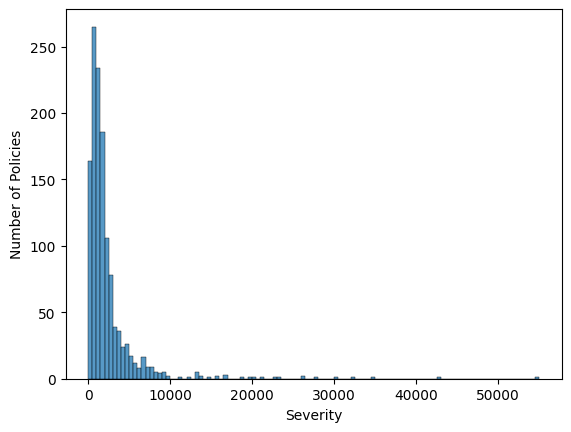

In [4]:
q1a = sns.histplot(train_data[target],binwidth=500)
q1a.set_ylabel("Number of Policies")
q1a.set_xlabel("Severity")

Text(0.5, 0, 'Severity')

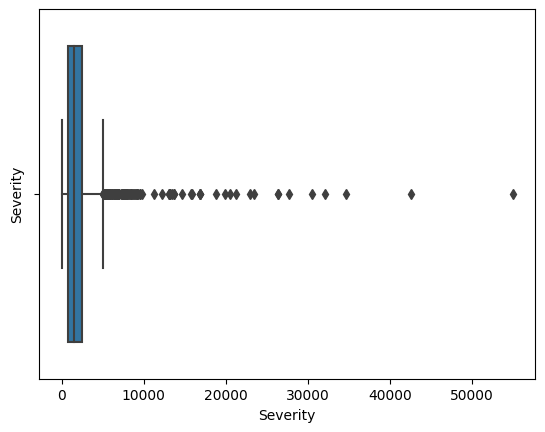

In [5]:
q1b = sns.boxplot(data=train_data,x = target, orient="h")
q1b.set_ylabel("Severity")
q1b.set_xlabel("Severity")

In [6]:
n_sample = train_data.shape[0]
y_train = train_data[target]
o_train = train_data[exposure]
X0_train = train_data[[target]]
X0_train.insert(0, 'Intercept', 1.0)
X0_train = X0_train.drop(columns=target)
maxIter = 20
tolS = 1e-7
resultList = Regression.GammaRegression (X0_train, y_train, offset = o_train, maxIter = maxIter, tolSweep = tolS)
llk = resultList[3]
nonAliasParam = resultList[4]
outIterationTable = resultList[5]
y_pred = resultList[6]
aic = -2 * llk + 2 * len(nonAliasParam)
bic = -2 * llk + len(nonAliasParam) * math.log(n_sample)
print("###############################################################################################################")
# Question 1.2
print("Log Liklehood = " + str(llk), "AIC = " + str(aic), "BIC = " + str(bic))

###############################################################################################################
Log Liklehood = -11171.287135771177 AIC = 22344.574271542355 BIC = 22349.724188378488


In [7]:
def create_categorical_value(dfs, column_name):
    u = dfs[column_name].astype('category')
    u_freq = u.value_counts(ascending=True)
    pm = u.cat.reorder_categories(list(u_freq.index))
    term_df_type = pandas.get_dummies(pm)
    return term_df_type

In [8]:
def run_against_all(dfs, init_cols, categorical_cols, previous_train, output_train, ll, dv):
    step_detail = []
    output_list = []
    for i in init_cols:
        if i in categorical_cols:
            new_train = previous_train.join(create_categorical_value(dfs, i), rsuffix=i)
        else:
            new_train = previous_train.join(dfs[i], rsuffix=i)
        maxIter = 20
        tolS = 1e-7
        regression_output = Regression.GammaRegression(new_train, output_train, offset = None, maxIter = maxIter, tolSweep = tolS)
        ll_1 = regression_output[3]
        dv_1 = len(regression_output[4])
        dev_chisq = 2 * (ll_1 - ll)
        deviance_df = dv_1 - dv
        dev_sig = chi2.sf(dev_chisq, deviance_df)
        step_detail.append([str(i), dv_1, ll_1, dev_chisq, deviance_df, dev_sig])
        output_list.append(regression_output)
    step_df = pd.DataFrame(step_detail)
    chosen_value = step_df[step_df[5] == step_df[5].min()]
    chosen_output = output_list[step_df.index[step_df[5] == step_df[5].min()].tolist()[0]]
    return chosen_value.values, chosen_output

In [9]:
def forward_selector(data, target_col, init_cols, cat_columns):
    # First Run
    target_train = data[target_col]
    intercept_train = data[[target_col]]
    init = init_cols
    intercept_train.insert(0, 'Intercept', 1.0)
    intercept_train = intercept_train.drop(columns=target_col)
    maxIter = 20
    tolS = 1e-7
    intercept_result = Regression.GammaRegression(intercept_train, target_train, offset = None, maxIter = maxIter, tolSweep = tolS)
    step_summary = []
    ll = intercept_result[3]
    dv = len(intercept_result[4])
    dev_sig = 0
    threshold = 0.01
    value_outputs = None
    step_summary.append(['Intercept', dv, ll, np.nan, np.nan, np.nan])
    while dev_sig < threshold:
        run, s = run_against_all(data, init, cat_columns, intercept_train, target_train, ll, dv)
        run = run[0]
        ll = run[2]
        dv = run[1]
        dev_sig = run[5]
        if dev_sig < threshold:
            value_outputs = s
            if run[0] in cat_columns:
                intercept_train = intercept_train.join(create_categorical_value(data, run[0]), rsuffix=str(run[0]))
            else:
                intercept_train = intercept_train.join(data[run[0]], rsuffix=str(run[0]))
            init.remove(run[0])
            step_summary.append([run[0], dv, ll, run[3], run[4], run[5]])
    step_summary = pd.DataFrame(step_summary)
    return step_summary, value_outputs, intercept_result

In [10]:
int_pred = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED", "URBANICITY",
            'HOMEKIDS', 'KIDSDRIV', "AGE", "BLUEBOOK", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", "MVR_PTS", "TIF",
            "TRAVTIME"]
df, outps, train = forward_selector(train_data, target, int_pred, cat_cols)
print("###############################################################################################################")
# Question 2.1
print(df)

###############################################################################################################
           0   1             2           3   4               5
0  Intercept   1 -11,171.28714         NaN NaN             NaN
1   BLUEBOOK   2 -11,157.33324 27.90779111 1.0 1.272364058e-07
2    MSTATUS   3 -11,145.90691  22.8526561 1.0 1.749074512e-06
3    RED_CAR   4 -11,141.88088 8.052062275 1.0  0.004545188514
4   CAR_TYPE   9 -11,133.50323 16.75529552 5.0  0.004988046005
5        YOJ  10 -11,129.52171 7.963049681 1.0  0.004774190534
6    CAR_AGE  11 -11,125.76473 7.513957446 1.0  0.006122271043


In [11]:
aic = -2 * outps[3] + 2 * len(outps[4])
bic = -2 * outps[3] + len(outps[4]) * math.log(n_sample)

print("###############################################################################################################")
# Question 2.2
print("AIC = " + str(aic), "BIC = " + str(bic))

###############################################################################################################
AIC = 22273.529459411366 BIC = 22330.178544608818


In [12]:
print("###############################################################################################################")
# Question 2.3
print(outps[0])

###############################################################################################################
                  Estimate  Standard Error   Lower 95% CI   Upper 95% CI  Exponentiated
Intercept      7.309887525    0.1076713062    7.098855642    7.520919407   1,495.009028
BLUEBOOK     0.01585228019  0.004418172537 0.007192821135  0.02451173924    1.015978594
No            0.3190459004   0.06553979011   0.1905902722   0.4475015286    1.375814474
Yes                    0.0             0.0            0.0            0.0            1.0
yes           0.2279487416    0.0744272514  0.08207400936   0.3738234738    1.256020942
no                     0.0             0.0            0.0            0.0            1.0
Panel Truck  -0.0331284244    0.1370213597  -0.3016853545   0.2354285057    0.967414312
Van         -0.06256364797    0.1213464214  -0.3003982636   0.1752709676    0.939353273
Sports Car   0.04995090134   0.08932750048  -0.1251277824   0.2250295851    1.051219482
Minivan 

In [13]:
def distance_corr(x, y):
    # Calculate the Adjusted Distance for x
    x_new = pd.DataFrame(x)
    y_new = pd.DataFrame(y)
    x_new = x_new.dropna()
    y_new = y_new.dropna()
    x_new = x_new.fillna(0)
    i = x_new.to_numpy().T[0]
    n = len(i)
    distance_matrix_x = pd.DataFrame(np.abs(i[:, None] - i))
    distance_matrix_x = distance_matrix_x.sub(distance_matrix_x.mean(axis=0), axis=1)
    distance_matrix_x = distance_matrix_x.sub(distance_matrix_x.mean(axis=1), axis=0)
    emp_dist_x = distance_matrix_x.pow(2)
    emp_dist_x = emp_dist_x.values.sum() / (n ** 2)

    # Calculate the Adjusted Distance for y
    y_new = y_new.fillna(0)
    d = y_new.to_numpy().T[0]
    n = len(i)
    distance_matrix_y = pd.DataFrame(np.abs(d[:, None] - d))
    distance_matrix_y = distance_matrix_y.sub(distance_matrix_y.mean(axis=0), axis=1)
    distance_matrix_y = distance_matrix_y.sub(distance_matrix_y.mean(axis=1), axis=0)
    emp_dist_y = distance_matrix_y.pow(2)
    emp_dist_y = emp_dist_y.values.sum() / (n ** 2)

    # Calculate the Distance covariance
    emp_dist_xy = distance_matrix_x.mul(distance_matrix_y, axis="index")
    emp_dist_xy = emp_dist_xy.values.sum() / (n ** 2)

    # Calculate the Distance Correlation Coefficient

    if (emp_dist_x * emp_dist_y) != 0:
        distance_correlation_coeff = math.sqrt(emp_dist_xy / (math.sqrt(emp_dist_x * emp_dist_y)))
    else:
        distance_correlation_coeff = np.nan
    return distance_correlation_coeff


In [14]:
def PearsonCorrelation (x, y):
   '''Compute the Pearson correlation between two arrays x and y with the
   same number of values

   Argument:
   ---------
   x : a Pandas Series
   y : a Pandas Series
   
   Output:
   -------
   rho : Pearson correlation
   '''
   
   dev_x = x - np.mean(x)
   dev_y = y - np.mean(y)
   
   ss_xx = np.mean(dev_x * dev_x)
   ss_yy = np.mean(dev_y * dev_y)

   if (ss_xx > 0.0 and ss_yy > 0.0):
      ss_xy = np.mean(dev_x * dev_y)
      rho = (ss_xy / ss_xx) * (ss_xy / ss_yy)
      rho = np.sign(ss_xy) * np.sqrt(rho)
   else:
      rho = np.nan
      
   return (rho)

In [26]:
def find_metrics(y_actual, y_predicted):
      y_simple_residual = y_actual - y_predicted
      mse = np.mean(np.power(y_simple_residual, 2))
      rmse = np.sqrt(mse)
      rel_error = mse / np.var(y_actual, ddof = 0)
      dist_corr = distance_corr(y_actual, y_predicted)
      pearson_corr = PearsonCorrelation(y_actual, y_predicted)
      ape = np.abs(y_simple_residual) / y_actual
      mape = np.mean(ape)
      output_metric = pd.DataFrame({"RMSE": [np.round(rmse, 8)], "Relative Error": [np.round(rel_error, 8)],"Pearson Correlation": [np.round(pearson_corr, 8)],"Distance Correlation": [np.round(dist_corr, 8)], "Mean Absolute Proportion Error": [np.round(mape, 8)]})
      return output_metric

In [27]:
y_train = train_data[target].values
y_pred = outps[6]

In [28]:
print("###############################################################################################################")
# Question 3.1
print(find_metrics(y_train, resultList[6]))

###############################################################################################################
          RMSE  Relative Error  Pearson Correlation  Distance Correlation  Mean Absolute Proportion Error
0 3,667.071627             1.0                 -0.0                   NaN                      1.88618305


In [18]:
print("###############################################################################################################")
# Question 3.2
print(find_metrics(y_train, outps[6]))

###############################################################################################################
          RMSE  Relative Error  Pearson Correlation  Distance Correlation  Mean Absolute Proportion Error
0 3,613.455853      0.97097203            0.1706248            0.15112268                      1.82166692


In [29]:
y_simple_residual = y_train - y_pred
pearson_residual = y_simple_residual / np.sqrt(y_pred)
pearson_chi_statistic = np.sum((y_train - y_pred) ** 2 / y_pred)
r_vec = y_train / y_pred
di_2 = 2 * (r_vec - np.log(r_vec) - 1)
devResid = np.where(y_simple_residual > 0, 1.0, -1.0) * np.sqrt(di_2)
dof = n_sample - len(outps[4])
deviance_chisq = np.sum(np.power(devResid, 2.0))
pearson_sig = chi2.sf(pearson_chi_statistic, dof)
deviance_sig = chi2.sf(deviance_chisq, dof)
comparative_output = pd.DataFrame(
    {"Type": ["Pearson", "Deviance"], "Statistic": [pearson_chi_statistic, deviance_chisq],
     "Degrees of Freedom": [dof, dof], "Significance": [pearson_sig, deviance_sig]})
print("###############################################################################################################")
# Question 3.3
print(comparative_output)

###############################################################################################################
       Type     Statistic  Degrees of Freedom  Significance
0   Pearson 5,887,084.651                1263           0.0
1  Deviance  1,183.201598                1263  0.9462054624


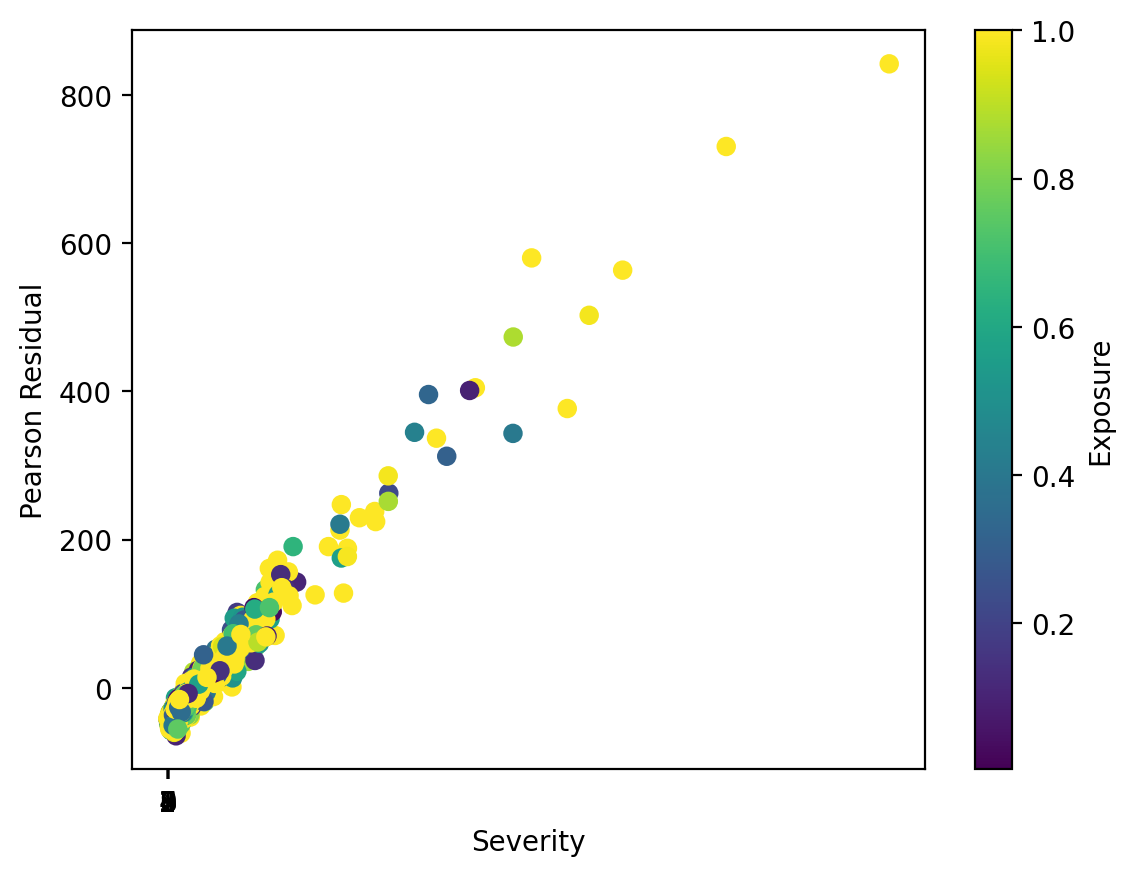

In [20]:
# Question 4.1
plt.figure(dpi=200)
sg = plt.scatter(y_train, pearson_residual, c=train_data[exposure], marker='o', cmap="viridis")
plt.xlabel('Severity')
plt.ylabel('Pearson Residual')
plt.xticks(range(10))
plt.grid(axis='both')
plt.colorbar(sg, label='Exposure')
plt.grid()
plt.show()

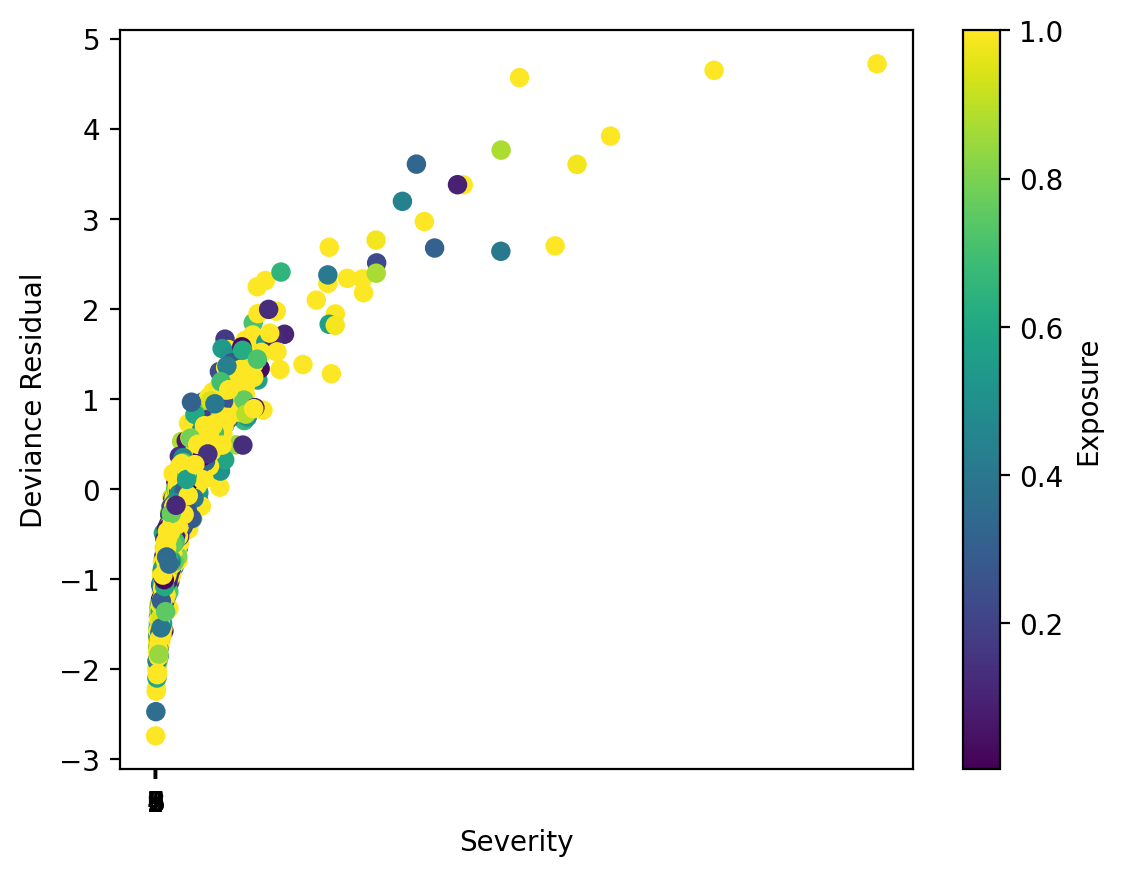

In [21]:
# Question 4.2
plt.figure(dpi=200)
sg = plt.scatter(y_train, devResid, c=train_data[exposure], marker='o', cmap="viridis")
plt.xlabel('Severity')
plt.ylabel('Deviance Residual')
plt.xticks(range(10))
plt.grid(axis='both')
plt.colorbar(sg, label='Exposure')
plt.grid()
plt.show()